Import used libraries

In [1]:
import requests
import pandas as pd

from tqdm import tqdm
from bs4 import BeautifulSoup

Scrape the data of all UYL finalists from transfermarkt into a DataFrame

In [2]:
transforms = [
    lambda a : int(a.string),
    lambda a : {"id": int(a.find('a').get("id")), "name": a.find('a').string},
    lambda a : [str(img.get('alt')) for img in a.findAll('img')],
    lambda a : [str(img.get('alt')) for img in a.findAll('img')],
    lambda a : int(a.string),
    lambda a : int(a.string) if a.string != '-' else 0,
]

keys = []

def import_data(soup):
    data = []
    table = soup.find('table')
    keys = [th.string.lower() for th in table.find('thead').findAll('th')]

    for row in table.find('tbody').findChildren('tr', recursive=False):
        try:
            data.append({
                keys[i] : transforms[i](td)
                for i, td in enumerate(row.findChildren('td', recursive=False))
                if i < len(transforms)
            })
        except (TypeError, ValueError) as e:
            print("FAILED: " )
            print(row)
            raise e
    
    
    return data


df = pd.DataFrame(columns=keys)

url = 'https://www.transfermarkt.com/uefa-youth-league/endspielteilnehmer/pokalwettbewerb/19YL?page='
headers = {"User-Agent":"Mozilla/5.0"}
n_pages = 10

for n_page in tqdm(range(n_pages)):
    page = requests.get(url + str(n_page+1), headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    df = df.append(import_data(soup))

100%|██████████| 10/10 [00:17<00:00,  1.52s/it]


We now have the necessary data:

In [3]:
df.head()

,#,player,nat.,teams,participations,wins
0,1,"{'id': 346315, 'name': 'Dujon Sterling'}","[England, Jamaica]",[Chelsea FC UEFA U19],3,2
1,2,"{'id': 504148, 'name': 'Tariq Lamptey'}","[England, Ghana]",[Chelsea FC UEFA U19],2,0
2,3,"{'id': 392766, 'name': 'George McEachran'}","[England, Scotland]",[Chelsea FC UEFA U19],2,0
3,4,"{'id': 331726, 'name': 'Tammy Abraham'}","[England, Nigeria]",[Chelsea FC UEFA U19],2,2
4,5,"{'id': 361081, 'name': 'Daishawn Redan'}","[Netherlands, Suriname]",[Chelsea FC UEFA U19],2,0


Let's clean it up a bit and separate player id from the player name:

In [4]:
df = pd.concat([df['player'].apply(pd.Series), df.drop(['#', 'player'], axis=1)], axis=1)
df.set_index('id', inplace = True)
df.index.rename('player_id', inplace=True)
df.head()

,name,nat.,teams,participations,wins
player_id,,,,,
346315,Dujon Sterling,"[England, Jamaica]",[Chelsea FC UEFA U19],3,2
504148,Tariq Lamptey,"[England, Ghana]",[Chelsea FC UEFA U19],2,0
392766,George McEachran,"[England, Scotland]",[Chelsea FC UEFA U19],2,0
331726,Tammy Abraham,"[England, Nigeria]",[Chelsea FC UEFA U19],2,2
361081,Daishawn Redan,"[Netherlands, Suriname]",[Chelsea FC UEFA U19],2,0


Do we have any players that have played for more than one club in the final?

In [5]:
[v for v in df.teams.to_list() if len(v) != 1]

[]

No, wo don't! Do all the club names end with ' UEFA U19'?

In [6]:
[v[0] for v in df.teams.to_list() if not v[0].endswith(' UEFA U19')]

[]

They do, so let's clean up the team name and rename the columns a bit...

In [7]:
df.teams = df.teams.apply(lambda x: x[0][0:-9])
df.columns = ['name', 'nationalities', 'team', 'participations', 'wins']

Much cleaner now:

In [8]:
df.head()

,name,nationalities,team,participations,wins
player_id,,,,,
346315,Dujon Sterling,"[England, Jamaica]",Chelsea FC,3,2
504148,Tariq Lamptey,"[England, Ghana]",Chelsea FC,2,0
392766,George McEachran,"[England, Scotland]",Chelsea FC,2,0
331726,Tammy Abraham,"[England, Nigeria]",Chelsea FC,2,2
361081,Daishawn Redan,"[Netherlands, Suriname]",Chelsea FC,2,0


Lets check how many individual players each team has ever had in UYL finals...

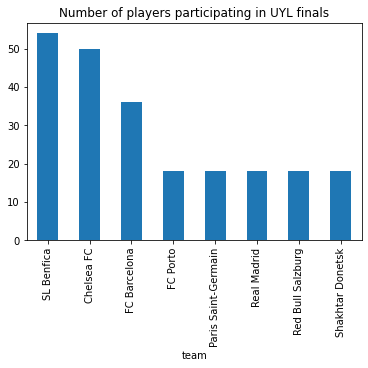

In [9]:
df.groupby('team').size().sort_values(ascending=False).plot.bar(title='Number of players participating in UYL finals')
pass

How many different players have won a UYL final for each team?

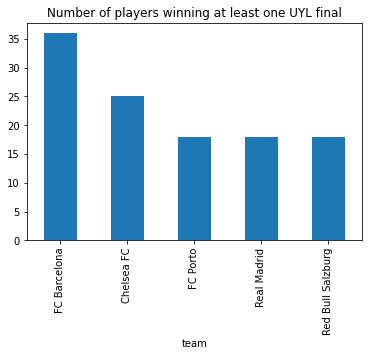

In [10]:
df[df.wins > 0].groupby('team').size().sort_values(ascending=False).plot.bar(title='Number of players winning at least one UYL final')
pass

These are the players to have won it more than once, turns out it's only been Chelsea players, 10 of them... No player has ever won it more than twice...

In [11]:
df[df.wins > 1].style.hide_index()

name,nationalities,team,participations,wins
Dujon Sterling,"['England', 'Jamaica']",Chelsea FC,3,2
Tammy Abraham,"['England', 'Nigeria']",Chelsea FC,2,2
Kasey Palmer,"['Jamaica', 'England']",Chelsea FC,2,2
Charlie Colkett,['England'],Chelsea FC,2,2
Jake Clarke-Salter,['England'],Chelsea FC,2,2
Ola Aina,"['Nigeria', 'England']",Chelsea FC,2,2
Brad Collins,['England'],Chelsea FC,2,2
Kyle Scott,"['United States', 'England']",Chelsea FC,2,2
Jay Dasilva,"['England', 'Wales']",Chelsea FC,2,2
Fikayo Tomori,"['England', 'Canada']",Chelsea FC,2,2


And how many players have played at least one UYL final, but never managed to win it (per club)?

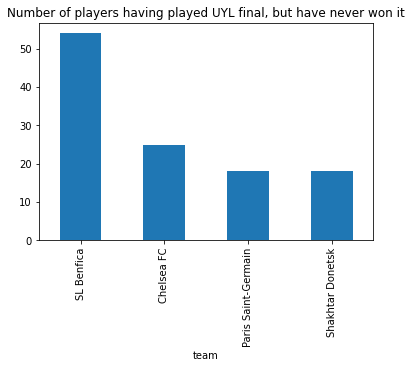

In [12]:
df[df.wins == 0].groupby('team').size().sort_values(ascending=False).plot.bar(title='Number of players having played UYL final, but have never won it')
pass

For each player, scrape the international cup statistics

In [13]:
player_stats_keys = ['player_id', 'season', 'competition', 'club', 'appearances', 'goals', 'assists', 'yellow', 'secondyellow', 'red', 'minutes']

def get_international_cup_stats(player_id):    
    def cleanup(s):
        s = s.rstrip("'") if s != '-' else '0'
        s = s.replace('.', '')
        return int(s) if s.isnumeric() else s

    url = 'https://www.transfermarkt.com/player-name/detaillierteleistungsdaten/spieler/' + str(player_id)
    headers = {"User-Agent":"Mozilla/5.0"}
    page = requests.get(url, headers=headers)
    
    soup = BeautifulSoup(page.content, 'html.parser')

    table = soup.find('div', string="International cups").parent.find('table')

    rows = table.find('tbody').findAll('tr', recursive = False)
    return [ 
        dict(zip(player_stats_keys, map(cleanup, [str(player_id), *[
                    (col.string if n != 3 else col.find('img').get('alt'))
                    for n, col in enumerate(row.findAll('td', recursive=False))
                    if n != 1
                  ]])))
        for row in rows
    ]

df_ps = pd.DataFrame(columns = player_stats_keys)

for player_id in tqdm(df.index):
    player_data = get_international_cup_stats(player_id)
    df_ps = df_ps.append(player_data)

100%|██████████| 230/230 [03:41<00:00,  1.12s/it]


Get only the appearances for the senior team

In [15]:
df_senior = df_ps[~df_ps.club.str.endswith('U19')]
df_senior = df_senior[df_senior.minutes > 0]
df_senior.head()

,player_id,season,competition,club,appearances,goals,assists,yellow,secondyellow,red,minutes
0,331726,20/21,Champions League,Chelsea FC,5,1,2,0,0,0,231
1,331726,19/20,Champions League,Chelsea FC,8,3,1,0,0,0,568
2,331726,19/20,UEFA Super Cup,Chelsea FC,1,0,1,0,0,0,46
0,236496,17/18,Europa League,Vitesse Arnhem,3,0,0,0,0,0,65
0,316551,18/19,Europa League Qualifying,Vitesse Arnhem,4,0,1,0,0,1,265


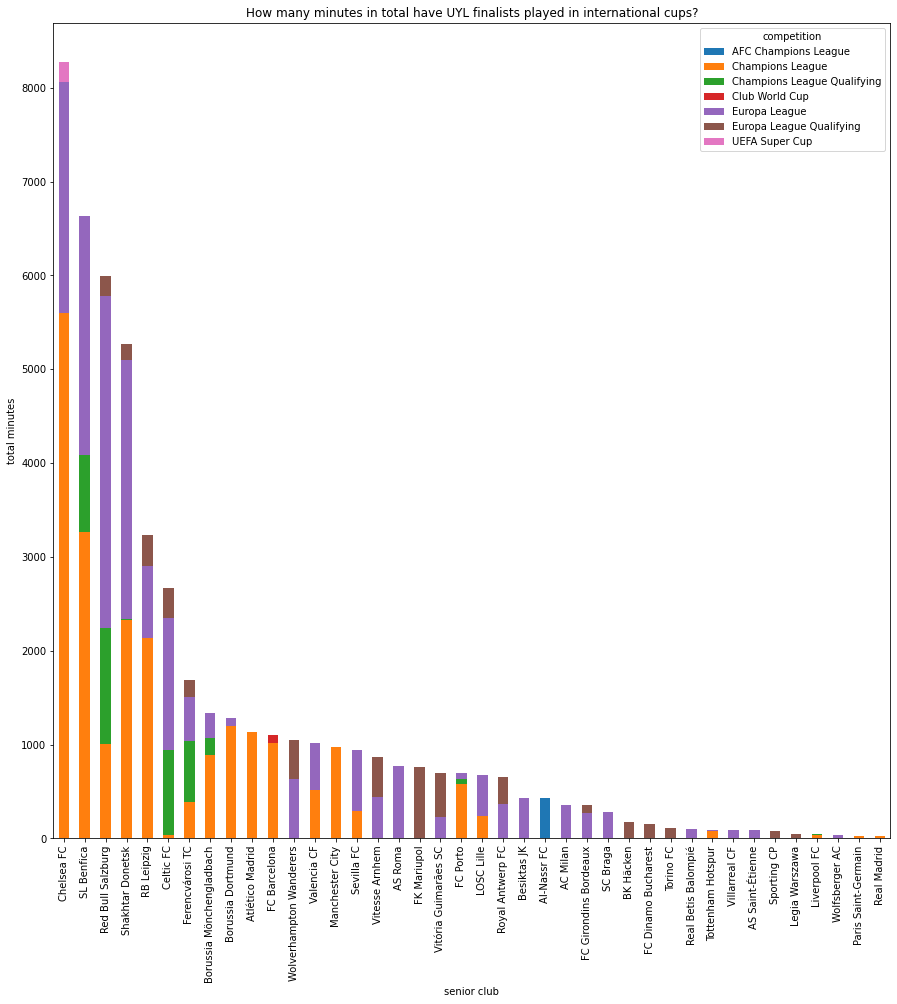

In [16]:
pd\
   .pivot_table(df_senior, values='minutes', index='club', columns='competition', aggfunc='sum', fill_value=0, margins=True) \
   .sort_values('All', ascending=False) \
   .drop('All', axis=1) \
   .drop('All', axis=0) \
   .plot.bar(xlabel="senior club", ylabel="total minutes", figsize=(15,15), stacked = True, title='How many minutes in total have UYL finalists played in international cups?')
pass

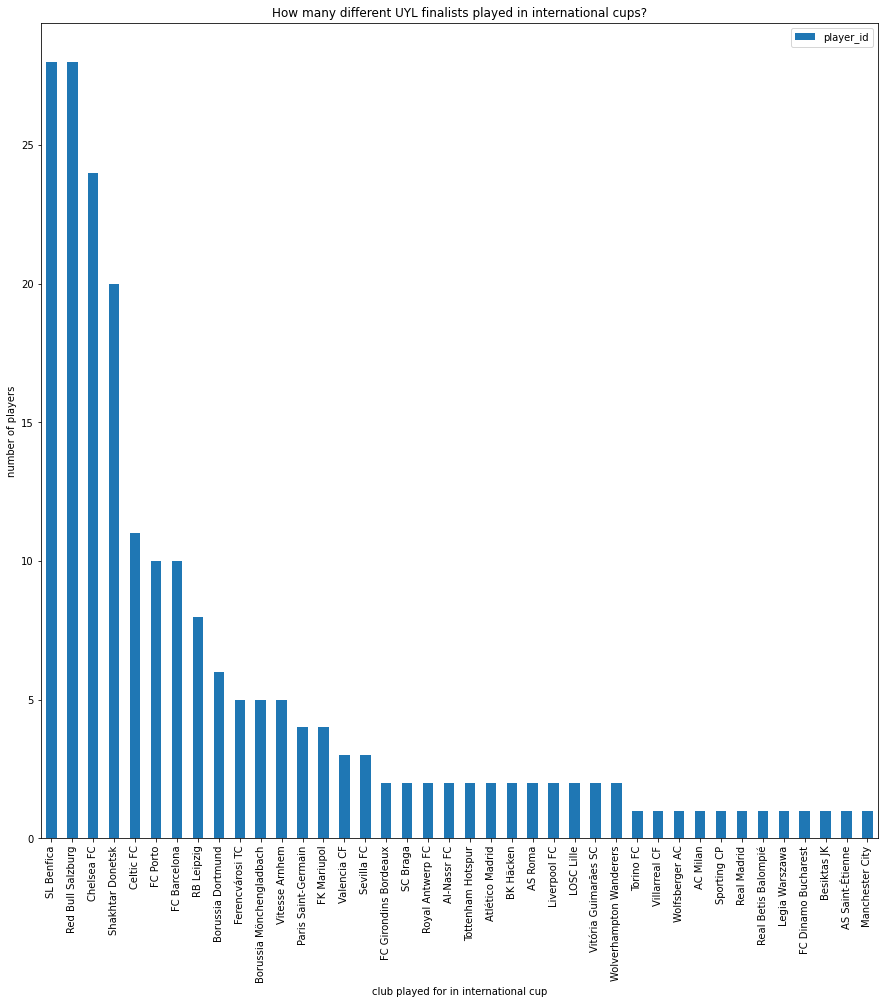

In [17]:
pd\
   .pivot_table(df_senior, values='player_id', index='club', aggfunc='count', fill_value=0) \
   .sort_values('player_id', ascending = False) \
   .plot.bar(xlabel='club played for in international cup', ylabel='number of players', figsize=(15,15), stacked = True, title='How many different UYL finalists played in international cups?', legend=True)
pass

Let's combine our two datasources so we can also check what the original youth team was...

In [18]:
df_combined = pd.merge(df_senior, df[["team", "name", "wins"]].add_prefix("uyl_"), left_on='player_id', right_on='player_id')

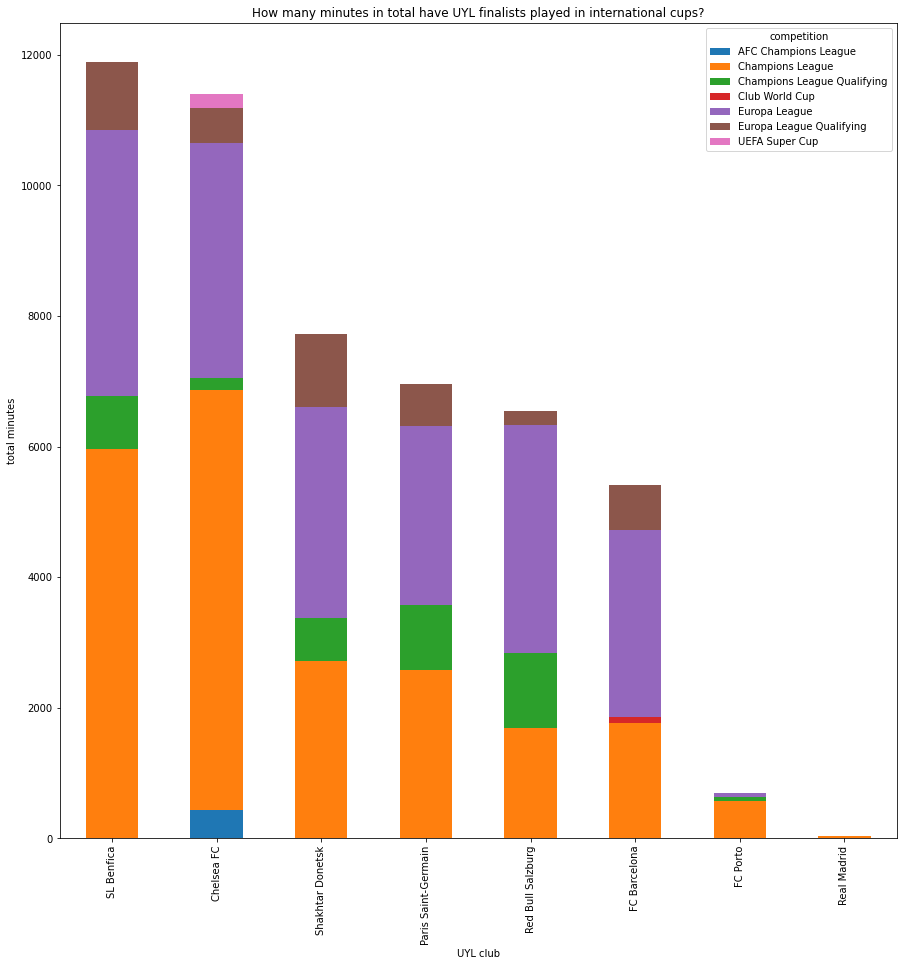

In [19]:
pd\
   .pivot_table(df_combined, values='minutes', index='uyl_team', columns='competition', aggfunc='sum', fill_value=0, margins=True) \
   .sort_values('All', ascending=False) \
   .drop('All', axis=1) \
   .drop('All', axis=0) \
   .plot.bar(xlabel="UYL club", ylabel="total minutes", figsize=(15,15), stacked = True, title='How many minutes in total have UYL finalists played in international cups?')
pass

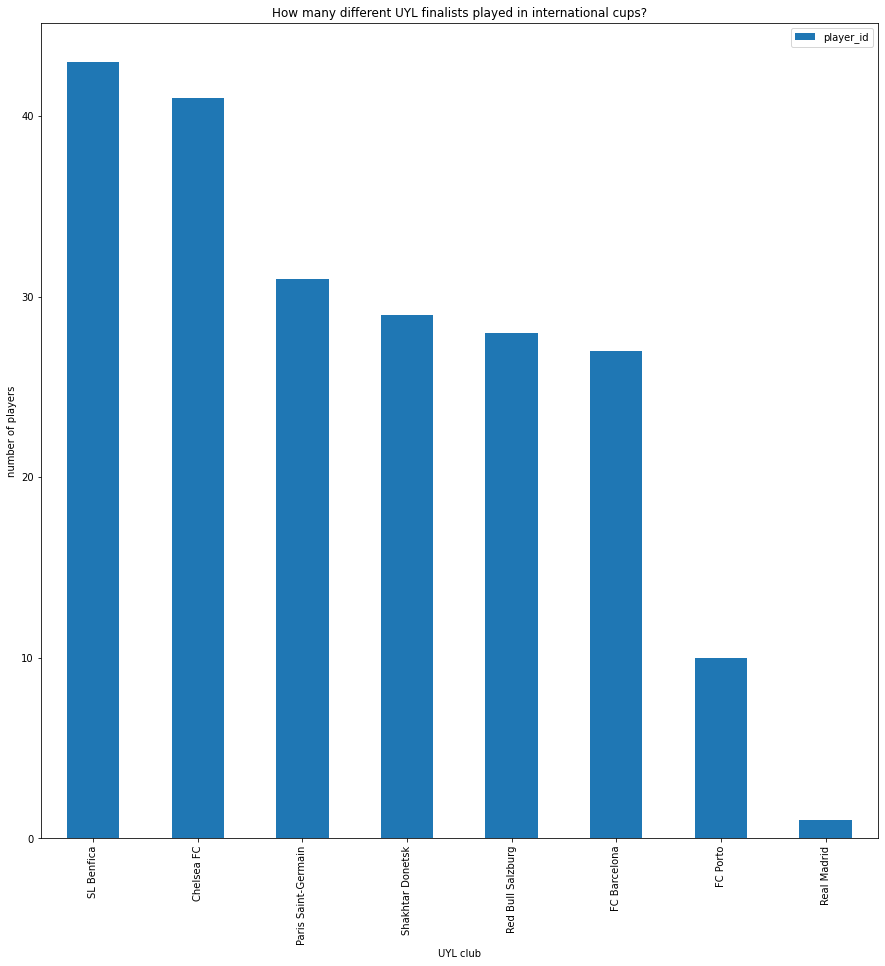

In [20]:
pd\
   .pivot_table(df_combined, values='player_id', index='uyl_team', aggfunc='count', fill_value=0) \
   .sort_values('player_id', ascending = False) \
   .plot.bar(xlabel='UYL club', ylabel='number of players', figsize=(15,15), stacked = True, title='How many different UYL finalists played in international cups?', legend=True)
pass

In [21]:
df_same_team = df_combined[df_combined.club == df_combined.uyl_team]

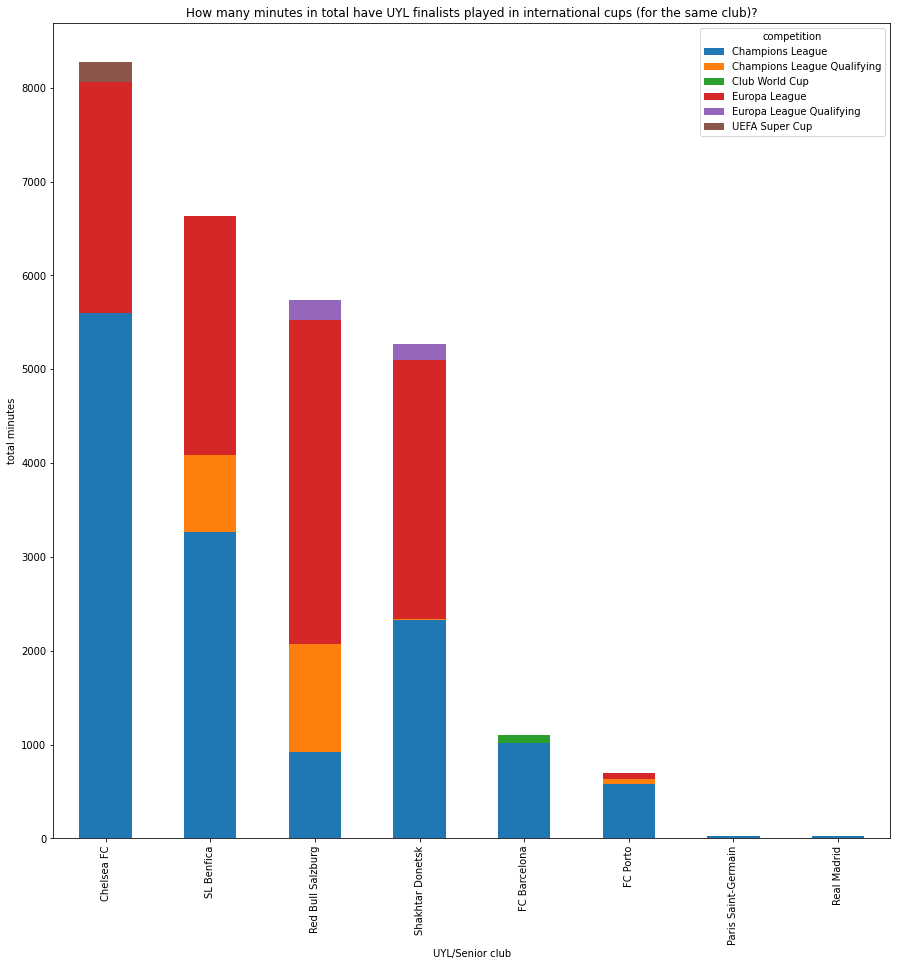

In [22]:
pd\
   .pivot_table(df_same_team, values='minutes', index='uyl_team', columns='competition', aggfunc='sum', fill_value=0, margins=True) \
   .sort_values('All', ascending=False) \
   .drop('All', axis=1) \
   .drop('All', axis=0) \
   .plot.bar(xlabel="UYL/Senior club", ylabel="total minutes", figsize=(15,15), stacked = True, title='How many minutes in total have UYL finalists played in international cups (for the same club)?')
pass

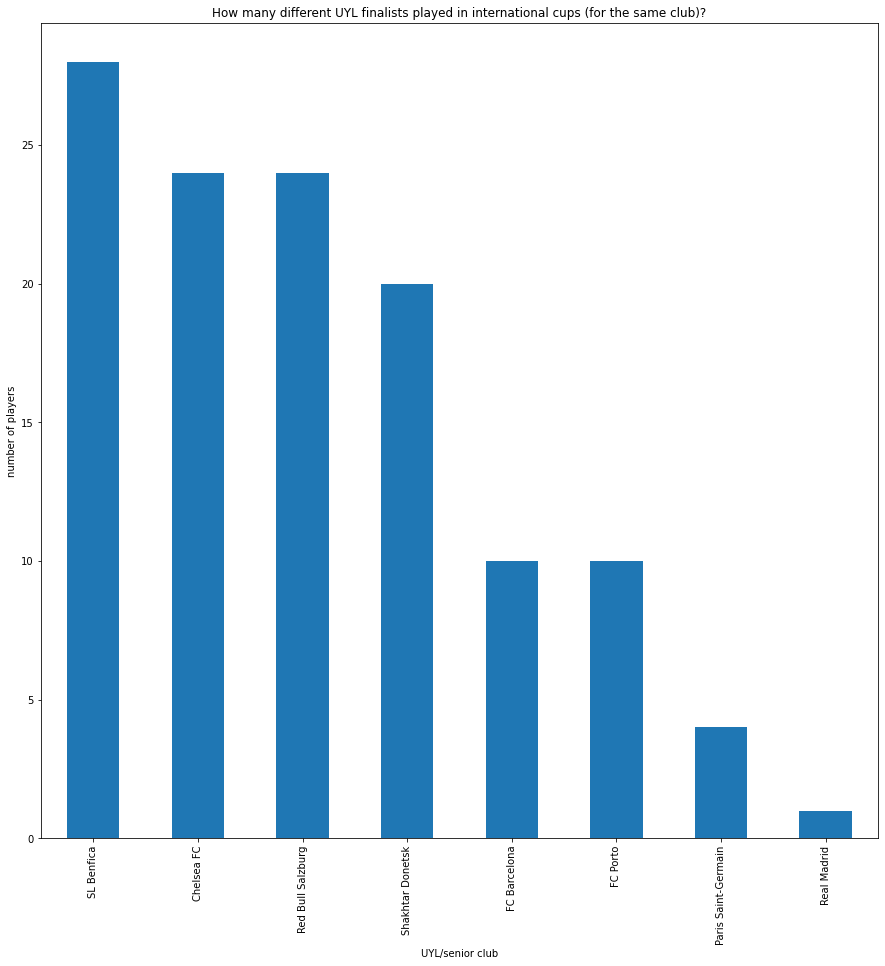

In [23]:
pd\
   .pivot_table(df_same_team, values='player_id', index='uyl_team', aggfunc='count', fill_value=0) \
   .sort_values('player_id', ascending = False) \
   .plot.bar(xlabel='UYL/senior club', ylabel='number of players', figsize=(15,15), stacked = True, title='How many different UYL finalists played in international cups (for the same club)?', legend=False)
pass

Save data to csv for easier later re-use and extra analysis...

In [24]:
df_combined.to_csv("uyl_player_data.csv")